In [1]:
!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow_hub

     |████████████████████████████████| 348.9MB 65kB/s 
     |████████████████████████████████| 501kB 38.0MB/s 
     |████████████████████████████████| 3.1MB 35.3MB/s 


In [2]:
!pip install -U -q PyDrive
!rm -r -f pdd_new
!git clone https://github.com/Kaliostrogoblin/PDD.git

     |████████████████████████████████| 993kB 6.4MB/s 
Cloning into 'PDD'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 270 (delta 12), reused 24 (delta 11), pack-reused 231
Receiving objects: 100% (270/270), 54.56 MiB | 24.26 MiB/s, done.
Resolving deltas: 100% (140/140), done.


In [3]:
import os
os.chdir('PDD')
# verify if we are in correct directory
os.listdir()

['.gitignore', 'pdd', 'README.md', '.git', 'server', 'examples']

In [4]:
#from pdd.utils.colab import download_file_from_gdrive
#from pdd.utils.colab import upload_file_to_gdrive
from google.colab import drive

drive.mount('/content/gdrive')

#file_id = 'your_file_id'
#download_file_from_gdrive('pdd_feature_extractor.h5', file_id)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from pdd.utils.data_utils import create_dataset_from_dir
from pdd.datasets.allcrops import load_data

train_data_path, test_data_path = load_data(split_on_train_test=True, random_state=13)

print("Loading datasets...")
train_dataset = create_dataset_from_dir(train_data_path, shuffle=True)
test_dataset = create_dataset_from_dir(test_data_path, shuffle=True)

100%|███████████████████| 15/15 [00:00<00:00, 122.26it/s]

Splitting on train and test...
Loading datasets...


## **QUANT LITE MODEL**

In [0]:
#TFLITE_MODEL = "/content/gdrive/My Drive/pdd_model_new/tfmodels/model_quant.tflite"
TFLITE_MODEL="/content/gdrive/My Drive/mobilenet_quant_v1_224.tflite"

In [6]:
import tensorflow as tf
# Load TFLite model and see some details about input/output

tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: Placeholder
shape: [  1 224 224   3]
type: <class 'numpy.uint8'>

== Output details ==
name: MobilenetV1/Predictions/Softmax
shape: [   1 1001]
type: <class 'numpy.uint8'>


In [0]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (len(test_dataset['data']), 256, 256, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (len(test_dataset['data']), 30))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [ 70 256 256   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [70 30]
type: <class 'numpy.float32'>


In [0]:
test_dataset['data'].dtype

dtype('float64')

In [0]:
#tflite_interpreter.set_tensor(input_details[0]['index'], train_dataset['data'])
tflite_interpreter.set_tensor(input_details[0]['index'], test_dataset['data'].astype('float32'))

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
#tflite_model_predictions = tflite_interpreter.get_tensor(len(test_dataset['target']), 30)
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (70, 30)


In [0]:
import numpy as np
from numpy import load

In [0]:
np.savez("/content/gdrive/My Drive/pdd_model_new/tfmodels/model_quant.npz", tflite_pred=tflite_model_predictions, y_true=test_dataset['target'])
data = load('/content/gdrive/My Drive/pdd_model_new/tfmodels/model_quant.npz')

In [0]:
data['tflite_pred'].argmax(axis=1)

array([ 4,  2,  4,  9,  1, 13, 14,  8,  3, 10, 13,  1,  8,  7,  6, 13,  7,
        4, 14,  2,  0,  5,  1,  8,  5,  6, 11,  5, 12,  7, 10,  5,  6,  3,
        6, 14, 11,  1,  9, 13, 12, 11,  8,  3,  9,  1,  0,  1,  4,  6, 10,
        8,  0,  3,  6, 12,  7,  8,  8, 13, 11, 10,  7,  0, 11,  1, 14,  2,
        9,  6])

In [0]:
data['tflite_pred'].argmax(axis=1)==data['y_true']

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True])

In [0]:
data['tflite_pred']

array([[1.87965087e-03, 6.73165050e-06, 2.86131421e-06, ...,
        1.54478990e-08, 1.04008038e-08, 1.03053530e-07],
       [5.82091707e-05, 2.96879385e-04, 9.93801415e-01, ...,
        2.52842565e-08, 7.07166876e-08, 1.17854796e-07],
       [2.20670924e-03, 3.70958704e-03, 6.85335772e-06, ...,
        9.91005322e-07, 1.15304715e-06, 1.88134402e-06],
       ...,
       [3.60806880e-04, 4.99374815e-04, 9.90491807e-01, ...,
        7.34836760e-08, 1.01314576e-07, 5.99192333e-07],
       [1.66398429e-04, 5.97317819e-04, 5.11961468e-02, ...,
        7.94274456e-07, 9.49173511e-07, 3.99438659e-06],
       [2.48946817e-05, 2.57327105e-03, 7.39640427e-06, ...,
        3.52755023e-07, 2.05180754e-07, 1.81896780e-07]], dtype=float32)

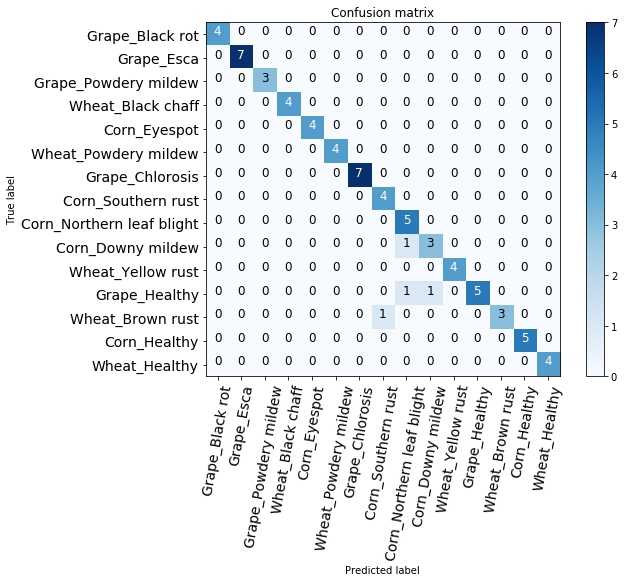

In [0]:
from pdd.utils.metrics_vis import plot_confusion_matrix
plot_confusion_matrix(y_true=test_dataset['target'], 
                      y_pred=data['tflite_pred'].argmax(axis=1),
                      target_names=test_dataset['target_names'],savefig=True)

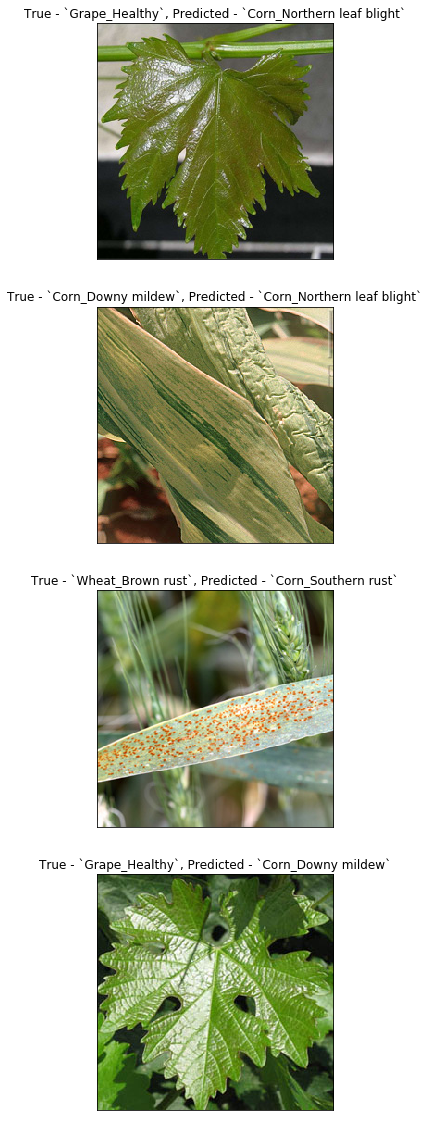

In [0]:
from pdd.utils.metrics_vis import plot_incorrect_predictions
plot_incorrect_predictions(imgs=test_dataset['data'], 
                           y_true=test_dataset['target'],
                           y_pred=data['tflite_pred'].argmax(axis=1),
                           target_names=test_dataset['target_names'],
                           savefig=True)

In [0]:
!cp 'confusion_matrix.png' "/content/gdrive/My Drive/pdd_model_new/tfmodels/model_quant_confusion_matrix.png"
!cp 'incorrect_preds.png' "/content/gdrive/My Drive/pdd_model_new/tfmodels/model_quant_incorrect_preds.png"

## **LITE MODEL**

In [0]:
TFLITE_MODEL = "/content/gdrive/My Drive/pdd_model_new/tfmodels/model.tflite"

In [0]:
tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [  1 256 256   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [ 1 30]
type: <class 'numpy.float32'>


In [0]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (len(test_dataset['data']), 256, 256, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (len(test_dataset['data']), 30))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [ 70 256 256   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [70 30]
type: <class 'numpy.float32'>


In [0]:
tflite_interpreter.set_tensor(input_details[0]['index'], test_dataset['data'].astype('float32'))

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
#tflite_model_predictions = tflite_interpreter.get_tensor(len(test_dataset['target']), 30)
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (70, 30)


In [0]:
np.savez("/content/gdrive/My Drive/pdd_model_new/tfmodels/model.npz", tflite_pred=tflite_model_predictions, y_true=test_dataset['target'])
data = load('/content/gdrive/My Drive/pdd_model_new/tfmodels/model.npz')

In [0]:
data['tflite_pred'].argmax(axis=1)

array([ 4,  2,  4,  9,  1, 13, 14,  2,  3, 10, 13,  1,  8,  7,  6, 13,  7,
        4, 14,  2,  0,  5,  1,  8,  5,  6, 11,  5, 12,  7, 10,  5,  6,  3,
        6, 14, 11,  1,  9, 13, 12, 11,  8,  3,  9,  1,  0,  1,  4,  6, 10,
        8,  0,  3,  6, 12,  7,  8,  8, 13, 11, 10,  7,  0, 11,  1, 14,  2,
       11,  6])

In [0]:
data['tflite_pred'].argmax(axis=1).size

70

In [0]:
data['tflite_pred'].argmax(axis=1)==data['y_true']

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True])

In [0]:
data['tflite_pred']

array([[1.9425759e-03, 7.2084608e-06, 3.2655471e-06, ..., 1.6026020e-08,
        1.2134975e-08, 1.1376062e-07],
       [7.3500727e-05, 3.8820159e-04, 9.9129385e-01, ..., 3.1712379e-08,
        9.1649646e-08, 1.4615057e-07],
       [2.6788099e-03, 3.0553069e-03, 5.8166002e-06, ..., 7.3506948e-07,
        9.6232316e-07, 1.5208032e-06],
       ...,
       [1.8176480e-04, 2.2957446e-04, 9.9735498e-01, ..., 2.9607090e-08,
        4.8279752e-08, 2.0502220e-07],
       [3.5611032e-05, 2.8783905e-05, 6.7923439e-04, ..., 1.2170477e-08,
        1.6752372e-08, 3.4485073e-08],
       [9.0239582e-06, 6.2693370e-04, 3.1026204e-07, ..., 8.5188434e-09,
        1.0619763e-08, 8.6059391e-09]], dtype=float32)

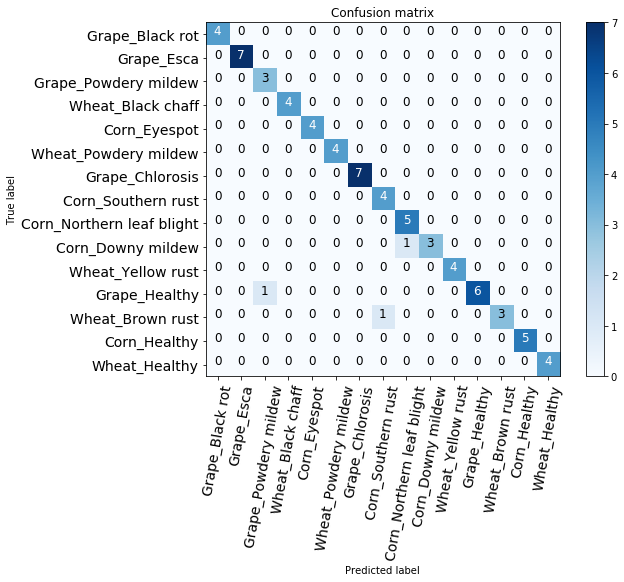

In [0]:
from pdd.utils.metrics_vis import plot_confusion_matrix
plot_confusion_matrix(y_true=test_dataset['target'], 
                      y_pred=data['tflite_pred'].argmax(axis=1),
                      target_names=test_dataset['target_names'],savefig=True)

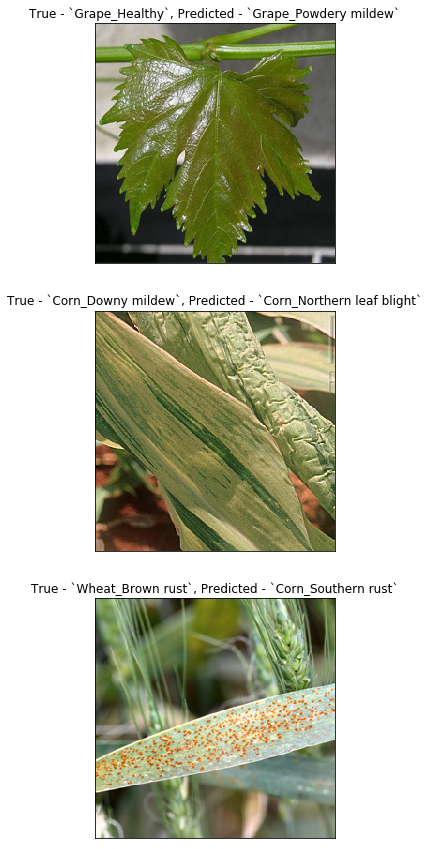

In [0]:
from pdd.utils.metrics_vis import plot_incorrect_predictions
plot_incorrect_predictions(imgs=test_dataset['data'], 
                           y_true=test_dataset['target'],
                           y_pred=data['tflite_pred'].argmax(axis=1),
                           target_names=test_dataset['target_names'],
                           savefig=True)

In [0]:
!cp 'confusion_matrix.png' "/content/gdrive/My Drive/pdd_model_new/tfmodels/model_confusion_matrix.png"
!cp 'incorrect_preds.png' "/content/gdrive/My Drive/pdd_model_new/tfmodels/model_incorrect_preds.png"

In [0]:
test_dataset['data'].max()

1.0